## Whale Network Analysis - Not kuramoto


In [6]:
import os
import pandas as pd
import networkx as nx # networkx for making networks
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [ ]:
# Checking WD 
#print("CWD:", os.getcwd())


In [22]:
# Load data
df = pd.read_csv("../Data/PrepData.csv")
# Just change NaN in coloumn to initation calls. Happens at start of each dataset. Otherwise there are no NaN
df["CallType"] = df["CallType"].fillna("InitiationCall") 

### Create networks for each group (G1, G2, G3) 

This only model the responders to the 

Nodes = Whales  
Edges = Calls from initiator to responder only  
Weights = How often that edge occured  

After identifying the initiator of the bout (first InitiationCall), i loop through every ResponseCall in the bout, and then an edge from the initiator to each of those responders.
Ex. if 5 whales responded in the same bout, I record 5 separate edges, one to each responder.


In [ ]:
# Create dictionaries to store the looped graphs and central whales fr each group
group_graphs = {}
# Stores the "centrality" scores ie. top whale per group
group_central_whales = {}

# Loop through each whale group (G1, G2, G3)
for group_id, df_group in df.groupby("Group"): # Subset into the three groups
    
    # Keeps track of how often one animal (initiator) responds to another (responder).
    edge_counts = Counter()

    # Group by 'bout' to identify interaction episodes
    for bout_id, group in df_group.groupby("bout"):
        group_sorted = group.sort_values("StartTime") # Sort time withiun the bout to get the first iniatior (Not sure if i need this))

        # Identify the initiator of the bout
        initiator_row = group_sorted[group_sorted["CallType"] == "InitiationCall"] # Subset the inititato in the bout
        responders = group_sorted[group_sorted["CallType"] == "ResponseCall"] # Subset the responders in the bout

        # Extract the initiator of the bout (first whale to make an initiation call)
        initiator = group_sorted[group_sorted["CallType"] == "InitiationCall"].iloc[0]["WhaleID"]

        # Loop through all responders in the bout
        for _, responder_row in responders.iterrows():
            responder = responder_row["WhaleID"]

        # !!Changing these matters! One allows the whale to count itself as a responder, the other doesn't!!
            if pd.notna(responder) and initiator != responder: # This checks if the resonder is not NaN and not the same whale responding to itself.
            #if pd.notna(responder): # Allow the whale to respond to itself
                edge_counts[(initiator, responder)] += 1



    # Build a directed graph and add weighted edges
    G = nx.DiGraph() # To create and save the graph for each group
    # For how many times one whale (u) initated a call where whale (v) responded
    for (u, v), w in edge_counts.items():
        G.add_edge(u, v, weight=w) # add the edge with the weight. w = number of times u initiated a call and v responded

    # Save graph by group
    group_graphs[group_id] = G

    # Compute node strengths (total in + out weights) for centrality
    node_strength = {} # Store each whale's total actvitiy score.
    for node in G.nodes(): # Node  = whale
        # Look at all whales (u) that sent calls to the node (whale). Adds up the weights of those edges, 
        # ie. how many times node (whale) responded.
        in_strength = sum(G[u][node]['weight'] for u in G.predecessors(node))
        # Look at all whales (v) that received calls from the node (whale). 
        # Adds up the weughts of how many times the node (whale) iniated to others.
        out_strength = sum(G[node][v]['weight'] for v in G.successors(node))
        # Combine the two strengths to get the total activity score for each whale
        node_strength[node] = in_strength + out_strength

    # Identify the most central whale (max(..., key=...) selected the dictionary key with the largest value 
    # ie. highest total strength)
    central_whale = max(node_strength, key=node_strength.get) if node_strength else None
    group_central_whales[group_id] = (node_strength, central_whale)

### Visualising Networks

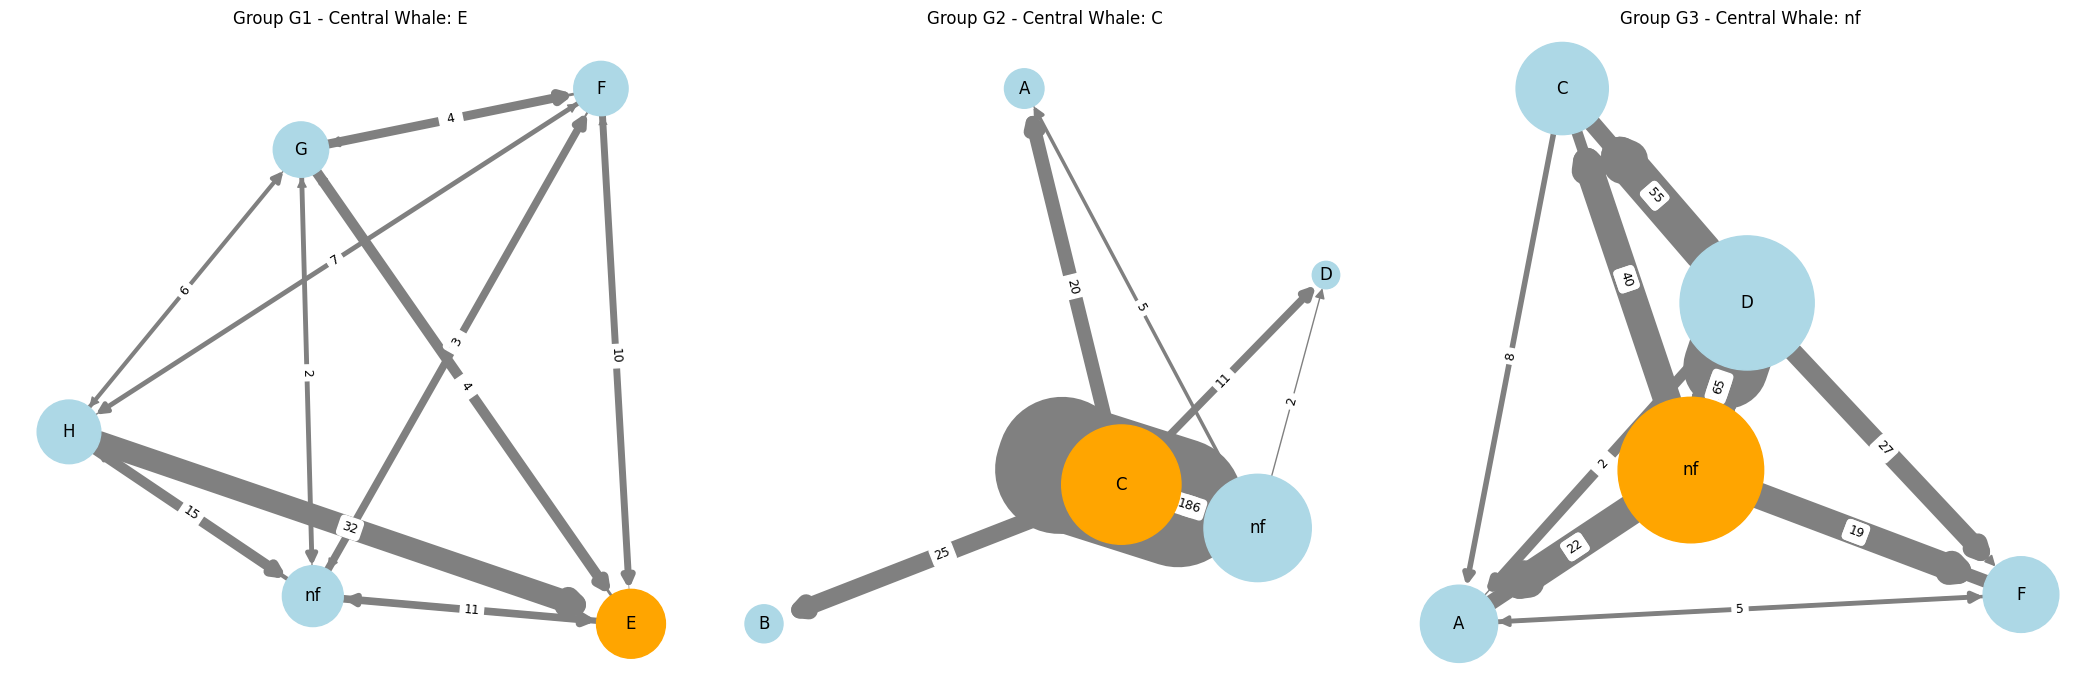

In [ ]:
# Draw each group's network
# Node size reflects total strength, orange node is the most central whale
fig, axes = plt.subplots(1, 3, figsize=(21,7))

for ax, (group_id, G) in zip(axes, group_graphs.items()):
    # Tuple unpacking: Extracting two variables from group_central_whales[group_id]: Dictionary of node strenghts 
    # (how active each whale is), and the ID of the most central whale based on strength
    strength_dict, central_whale = group_central_whales[group_id]
    # Use spring layout and space nodes out more for clarity (k controls spacing). Best layout options nx has for this data.
    k_value = 1.2 if group_id == "G1" else 2.5
    pos = nx.spring_layout(G, seed=42, k=k_value)
    
    # Set node size based on strength, and colour the central whale orange.
    node_sizes = [strength_dict.get(node, 1) * 30 for node in G.nodes()] # * 30 makes the nodes bigger
    node_colors = ['orange' if node == central_whale else 'lightblue' for node in G.nodes()]
    weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

    # Draw the graph with labels and edge weights. 
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes,
            edge_color='gray', width=weights, arrowsize=15, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=9)
    ax.set_title(f"Group {group_id} - Central Whale: {central_whale}")

plt.tight_layout()
plt.show()

### Dyadic Interaction 
Find the initiator - responder pairs, and count how many times each interaction occurs across bouts.   
“Whale A initiated, Whale B responded”   
Then aggregates how many times each dyad appeared  

In [ ]:
# Store each interaction as a row in a list
dyadic_stats = []

# Process by group (G1, G2, G3)
for group_id, df_group in df.groupby("Group"):
    
    # Loops through all communication bouts in each group
    for bout_id, group in df_group.groupby("bout"):
        # Sorts calls chronologically so the initiator appears first
        group_sorted = group.sort_values("StartTime")
        # Pulls out the whale who made the InitiationCall
        initiator_row = group_sorted[group_sorted["CallType"] == "InitiationCall"]
        # Separates out whales who made ResponseCalls 
        responders = group_sorted[group_sorted["CallType"] == "ResponseCall"]

       
        # Get the initiator ID for the bout
        initiator = initiator_row.iloc[0]["WhaleID"]

        for _, responder_row in responders.iterrows():
            responder = responder_row["WhaleID"]
            # if pd.notna(responder):  # Allow whale to respond to itself (just repeats the call), make the plot messy, 
            # but could be interesting to analyse
            if pd.notna(responder) and initiator != responder: # Initatior is skipped if it's the same as the responder
                dyadic_stats.append({
                    "Group": group_id,
                    "Initiator": initiator,
                    "Responder": responder
                })

# Convert to a DataFrame and count unique dyads
dyad_df = pd.DataFrame(dyadic_stats)
dyad_summary = dyad_df.groupby(["Group", "Initiator", "Responder"]).size().reset_index(name="CallCount")
dyad_summary.head()

,Group,Initiator,Responder,CallCount
0,G1,E,F,1
1,G1,E,G,4
2,G1,E,nf,9
3,G1,F,E,10
4,G1,F,G,4


### Visualise the dyadic networks 

- Directed network graphs (Initiatint animal → Responding animal)
- Heatmaps showing call frequencies

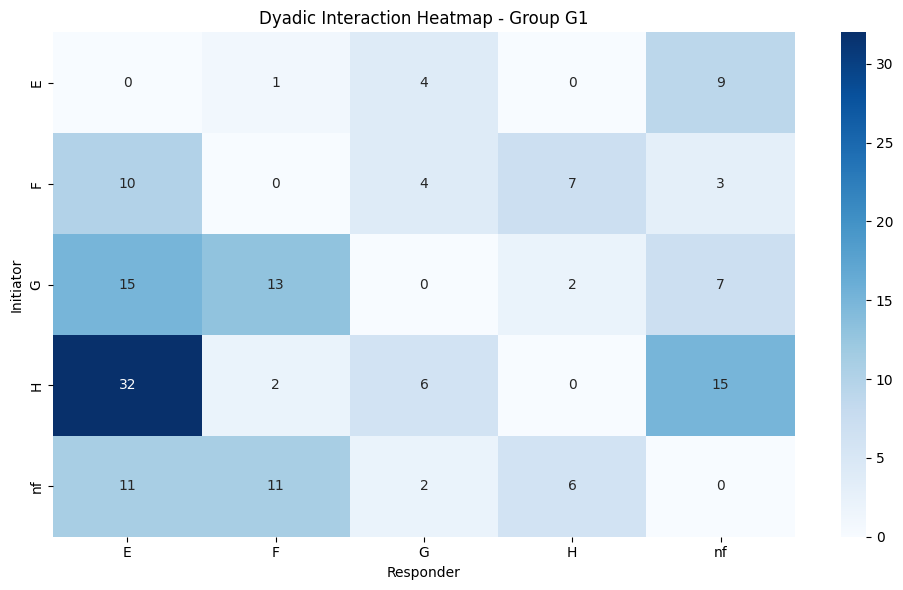

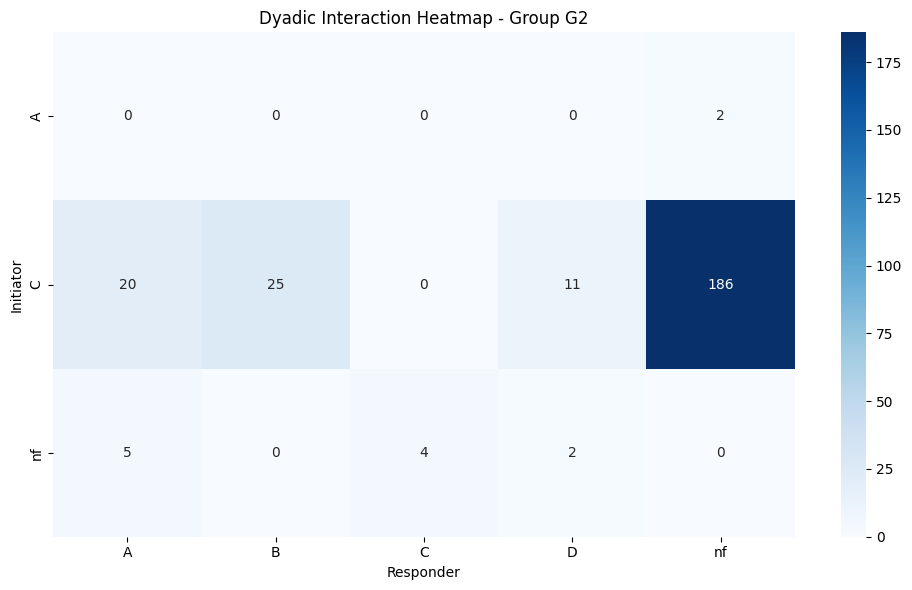

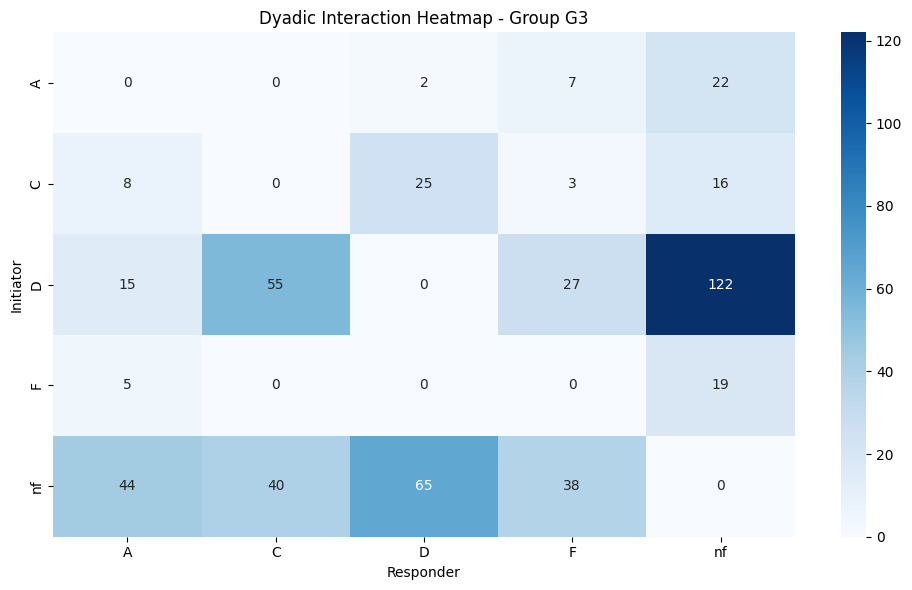

In [ ]:
# Create network and heatmap for each group based on dyadic interactions
dyad_graphs = {}

# Build directed graphs from dyad counts
for group_id, group_data in dyad_summary.groupby("Group"):
    G = nx.DiGraph()
    for _, row in group_data.iterrows():
        G.add_edge(row["Initiator"], row["Responder"], weight=row["CallCount"])
    dyad_graphs[group_id] = G

# Generate heatmaps
for group_id, group_data in dyad_summary.groupby("Group"):
    pivot = group_data.pivot(index="Initiator", columns="Responder", values="CallCount").fillna(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
    plt.title(f"Dyadic Interaction Heatmap - Group {group_id}")
    plt.xlabel("Responder")
    plt.ylabel("Initiator")
    plt.tight_layout()
    plt.show()